In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [19]:
"""
 The Zillow csv provides ZHVI for neighborhoods in the US.
 Zillow Home Value Index (ZHVI): A measure of the typical home value and market changes across a given region and housing type. 
 It reflects the typical value for homes in the 35th to 65th percentile range.
 More info about ZHVI: https://www.zillow.com/research/methodology-neural-zhvi-32128/
"""

df = pd.read_csv('Neighborhood_zillow.csv')
Neighborhoods_zillow_df = df.copy()
print("shape:", df.shape)


shape: (21628, 306)


In [ ]:
# print columns
print("Columns:")
print(df.columns.to_list())

chicago_df = df[df['City'] == "Chicago"]

# Different neighborhoods
print()
print("Chicago neighborhoods:")
print(chicago_df['RegionName'].unique()[:15])

# isolate Little Italy
print()
little_italy = chicago_df[chicago_df['RegionName'] == 'University Village - Little Italy']
print("Little Italy 2000-01", little_italy['2000-01-31'])
print("Little Italy 2024-09", little_italy['2024-09-30'])


In [ ]:
# Filter regions into different dataframes based on classification

# North Side
north_side_regions = [
    'Rogers Park', 'Edgewater', 'Uptown', 'Lake View', 'Lincoln Park', 
    'North Center', 'Lincoln Square', 'West Ridge', 'Irving Park', 
    'Albany Park', 'Avondale'
]
north_side_df = chicago_df[chicago_df['RegionName'].isin(north_side_regions)]

# South Side
south_side_regions = [
    'Armour Square', 'Bridgeport', 'Brighton Park', 'New City (Back of the Yards)', 
    'Englewood', 'Greater Grand Crossing', 'Hyde Park', 'Kenwood', 'Oakland', 
    'South Shore', 'Washington Park', 'Woodlawn', 'Chatham', 'South Chicago', 
    'Auburn Gresham', 'Calumet Heights', 'Roseland', 'Pullman', 'West Pullman', 
    'Riverdale'
]
south_side_df = chicago_df[chicago_df['RegionName'].isin(south_side_regions)]

# East Side
east_side_regions = ['Hegewisch', 'East Side', 'South Shore', 'Hyde Park', 'Kenwood']
east_side_df = chicago_df[chicago_df['RegionName'].isin(east_side_regions)]

# West Side
west_side_regions = [
    'Austin', 'East Garfield Park', 'West Garfield Park', 'North Lawndale', 
    'South Lawndale (Little Village)', 'Humboldt Park', 'Near West Side', 'West Town'
]
west_side_df = chicago_df[chicago_df['RegionName'].isin(west_side_regions)]

# Northwest Side
northwest_side_regions = [
    'Jefferson Park', 'Portage Park', 'Norwood Park', 'Dunning', 'Belmont Cragin', 
    'Montclare', 'Irving Park', 'Hermosa'
]
northwest_side_df = chicago_df[chicago_df['RegionName'].isin(northwest_side_regions)]

# Southwest Side
southwest_side_regions = [
    'Garfield Ridge', 'Archer Heights', 'Brighton Park', 'Gage Park', 'West Elsdon', 
    'West Lawn', 'Chicago Lawn (Marquette Park)', 'Ashburn', 'Clearing'
]
southwest_side_df = chicago_df[chicago_df['RegionName'].isin(southwest_side_regions)]

print("North Side neighborhoods: \n", north_side_df.head())
print("South Side neighborhoods: \n", south_side_df.head())
print("East Side neighborhoods: \n", east_side_df.head())
print("West Side neighborhoods: \n", west_side_df.head())
print("Northwest Side neighborhoods: \n", northwest_side_df.head())
print("Southwest Side neighborhoods: \n", southwest_side_df.head())

In [ ]:
# Unpivot date columns so data is more rectangular
def reshape_dates(df):
    # Identify date columns 
    date_columns = [col for col in df.columns if col.startswith('20')]
    
    # Melt dataframe to convert date columns into rows
    df_melted = df.melt(id_vars=['RegionID', 'SizeRank', 'RegionName'],
                        value_vars=date_columns,
                        var_name='Date', value_name='ZHVI')
    
    # Convert Date to datetime fromat
    df_melted['Date'] = pd.to_datetime(df_melted['Date'])

    return df_melted

reshaped_df = reshape_dates(chicago_df)
reshaped_df.head()

In [ ]:
# Filter for Lake View
lake_view_df = reshaped_df[reshaped_df['RegionName'] == 'Lake View']

# Plot ZHVI over time for Lake View
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='ZHVI', data=lake_view_df)
plt.title("ZHVI Value Over Time for Lake View")
plt.xlabel("Date")
plt.ylabel("ZHVI")
plt.show()

In [ ]:
pd.read_csv('Chicago_ZIP_Populations_2010.csv')

In [ ]:
# Clean up populations csv's
def clean_population(year):
    filename = 'Chicago_ZIP_Populations_' + str(year) + '.csv'
    df = pd.read_csv(filename)

    # Transpose columns and rows
    df = df.set_index('Label (Grouping)').transpose().reset_index()

    # Rename columns
    df.columns = ['Zip Code', 'Total']

    # Remove prefix from Zip codes
    df['Zip Code'] = df['Zip Code'].str[6:]
    df['Year'] = year
    
    return df

pop_2010 = clean_population(2010)
pop_2020 = clean_population(2020)

# Combine both years into one dataframe
population_df = pd.concat([pop_2010, pop_2020], ignore_index=True)

population_df

In [ ]:
# north side 

reshaped_north_side_df = reshape_dates(north_side_df)

# Plot ZHVI over time for Lake View
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='ZHVI', data=reshaped_north_side_df)
plt.title("ZHVI Value Over Time for North Side")
plt.xlabel("Date")
plt.ylabel("ZHVI")
plt.show()

In [23]:
Neighborhoods_zillow_df = Neighborhoods_zillow_df[Neighborhoods_zillow_df['City'] == "Chicago"]
Neighborhoods_zillow_df.to_csv('Chicago_Neighborhoods_Zillow.csv', index=False)

Best parameters: {'max_depth': 200, 'min_samples_split': 2, 'n_estimators': 1000}
RMSE: 599.3706176999113


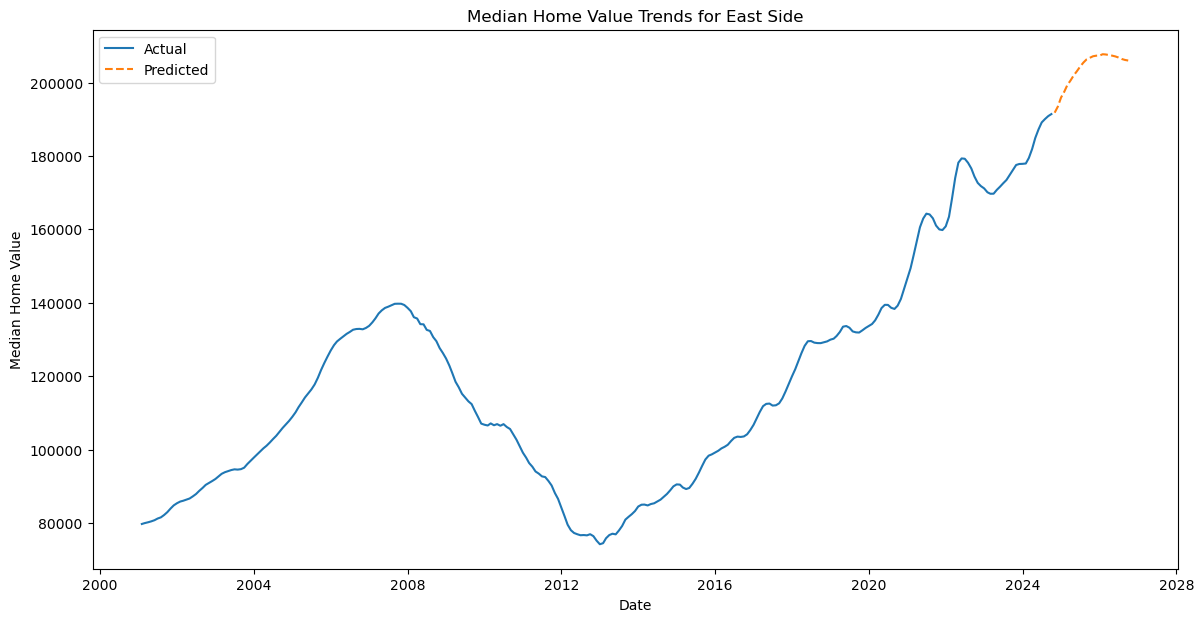

In [43]:

# 1. Load the dataset
df = pd.read_csv('Chicago_Neighborhoods_Zillow.csv')

# 2. Define the East Side regions
east_side_regions = [
    'Hegewisch', 'East Side', 'South Shore', 'Hyde Park', 'Kenwood'
]

# 3. Filter the DataFrame to include only the East Side regions
df = df[df['RegionName'].isin(east_side_regions)]

# 4. Reshape the data from wide to long format
# Identify non-date columns
non_date_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 
                 'State', 'City', 'Metro', 'CountyName']

# Reshape the DataFrame
df_long = df.melt(id_vars=non_date_cols, var_name='Date', value_name='MedianHomeValue')

# Convert 'Date' to datetime format
df_long['Date'] = pd.to_datetime(df_long['Date'])

# 5. Handle missing values
df_long.dropna(subset=['MedianHomeValue'], inplace=True)

# 6. Feature engineering
# Extract 'Year' and 'Month' from 'Date'
df_long['Year'] = df_long['Date'].dt.year
df_long['Month'] = df_long['Date'].dt.month

# 7. Create lag features
# Sort values
df_long.sort_values(['RegionName', 'Date'], inplace=True)

# Create lag features for the past 12 months
for lag in range(1, 13):
    df_long[f'Lag_{lag}'] = df_long.groupby('RegionName')['MedianHomeValue'].shift(lag)

# Drop rows with NaN values due to lagging
df_long.dropna(inplace=True)

# 8. Encode categorical variables
# One-hot encode 'RegionType' if necessary
df_encoded = pd.get_dummies(df_long, columns=['RegionType'], drop_first=True)

# 9. Define features and target variable
# Lag features
lag_features = [f'Lag_{lag}' for lag in range(1, 13)]
# Categorical features (if any)
categorical_features = [col for col in df_encoded.columns if col.startswith('RegionType_')]
# All features
features = lag_features + ['Year', 'Month'] + categorical_features

X = df_encoded[features]
y = df_encoded['MedianHomeValue']

# 10. Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# 11. Model training and selection
# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Simplify hyperparameter tuning for quicker runtime
param_grid = {
    'n_estimators': [1000],
    'max_depth': [200],
    'min_samples_split': [2]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

# Best estimator
best_model = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')

# 12. Evaluate the model
# Predictions on the training set
y_pred = best_model.predict(X)

# Calculate RMSE 
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE: {rmse}')

# 13. Forecast future values
# Predict the next 12 months
future_dates = pd.date_range(start=df_long['Date'].max() + pd.DateOffset(months=1),
                             periods=12, freq='ME')  #change periods to 24 for 2 years

# Create a DataFrame for future predictions
future_df = pd.DataFrame({'Date': future_dates})

# Prepare future predictions for each region
regions = df_long['RegionName'].unique()
future_predictions_list = []  # Use a list to collect DataFrames

for region in regions:
    # Get the last known data for the region
    region_data = df_encoded[df_encoded['RegionName'] == region].sort_values('Date')
    last_row = region_data.iloc[-1]
    
    # Initialize lag values
    lag_values = last_row[[f'Lag_{lag}' for lag in range(1, 13)]].values
    # The most recent value is 'MedianHomeValue' from the last row
    last_value = last_row['MedianHomeValue']
    
    # Create future data for the region
    temp_df = future_df.copy()
    temp_df['RegionName'] = region
    temp_df['Year'] = temp_df['Date'].dt.year
    temp_df['Month'] = temp_df['Date'].dt.month
    
    # Include any encoded 'RegionType' columns
    for col in categorical_features:
        temp_df[col] = last_row[col]
    
    # Initialize a DataFrame to store lag features
    predicted_values = []
    
    for i in range(len(temp_df)):
        # Create a dictionary to hold features for this date
        features_dict = {}
        # Set lag features
        for lag in range(1, 13):
            features_dict[f'Lag_{lag}'] = lag_values[lag-1]
        # Combine features
        features_input = pd.DataFrame(features_dict, index=[0])
        features_input['Year'] = temp_df.iloc[i]['Year']
        features_input['Month'] = temp_df.iloc[i]['Month']
        for col in categorical_features:
            features_input[col] = temp_df.iloc[i][col]
        # Ensure all features are present
        features_input = features_input[features]
        # Predict the median home value
        predicted_value = best_model.predict(features_input)[0]
        predicted_values.append(predicted_value)
        # Update lag values
        lag_values = np.roll(lag_values, 1)
        lag_values[0] = predicted_value  # The most recent lag is the predicted value
    
    # Add the predicted values to temp_df
    temp_df['PredictedMedianHomeValue'] = predicted_values
    
    # Collect temp_df in the list
    future_predictions_list.append(temp_df[['Date', 'RegionName', 'PredictedMedianHomeValue']])

# Concatenate all future predictions into a single DataFrame
future_predictions = pd.concat(future_predictions_list, ignore_index=True)

# 14. Visualize the predictions
# Select a region to visualize (e.g., 'East Side')
region_to_plot = 'East Side'  # Replace with an actual region name from your data

# Actual data
actual_data = df_long[df_long['RegionName'] == region_to_plot]

# Predicted data
predicted_data = future_predictions[future_predictions['RegionName'] == region_to_plot]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(actual_data['Date'], actual_data['MedianHomeValue'], label='Actual')
plt.plot(predicted_data['Date'], predicted_data['PredictedMedianHomeValue'],
         label='Predicted', linestyle='--')
plt.title(f'Median Home Value Trends for {region_to_plot}')
plt.xlabel('Date')
plt.ylabel('Median Home Value')
plt.legend()
plt.show()




Best parameters: {'max_depth': 200, 'min_samples_split': 2, 'n_estimators': 1000}
RMSE: 687.1411070859892


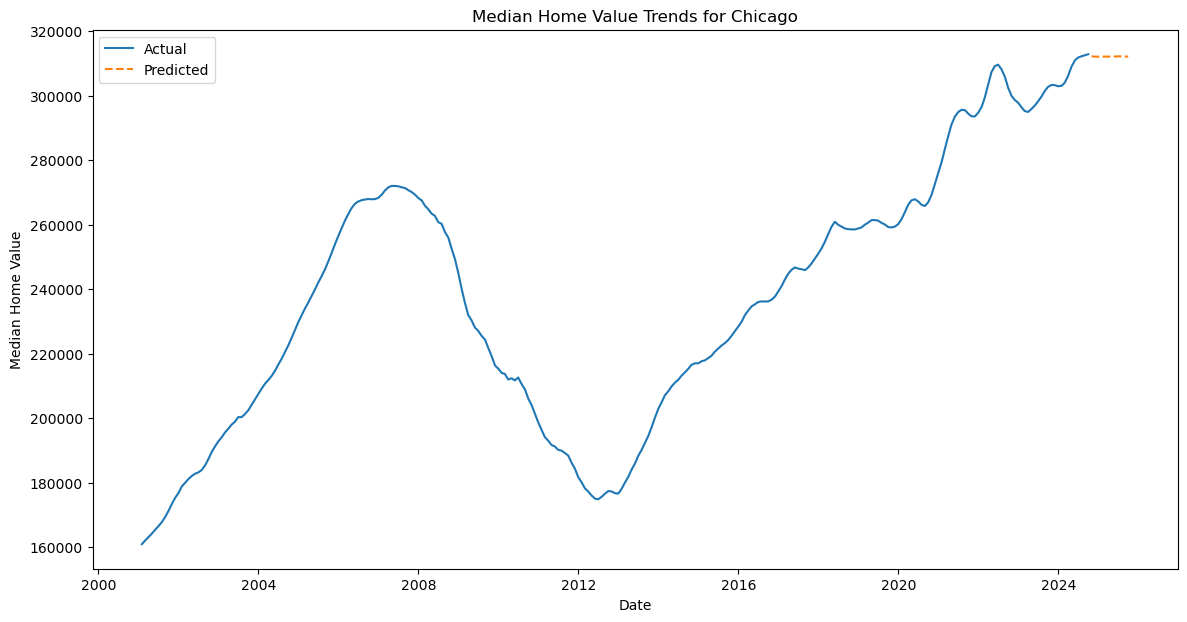

In [45]:

# 1. Load the dataset
df = pd.read_csv('Chicago_Neighborhoods_Zillow.csv')

# 2. Reshape the data from wide to long format
# Identify non-date columns
non_date_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 
                 'State', 'City', 'Metro', 'CountyName']

# Reshape the DataFrame
df_long = df.melt(id_vars=non_date_cols, var_name='Date', value_name='MedianHomeValue')

# Convert 'Date' to datetime format
df_long['Date'] = pd.to_datetime(df_long['Date'])

# 3. Handle missing values
df_long.dropna(subset=['MedianHomeValue'], inplace=True)

# 4. Aggregate the data across all regions
# Calculate the average median home value for each date
aggregate_data = df_long.groupby('Date')['MedianHomeValue'].mean().reset_index()

# 5. Feature engineering
# Extract 'Year' and 'Month' from 'Date'
aggregate_data['Year'] = aggregate_data['Date'].dt.year
aggregate_data['Month'] = aggregate_data['Date'].dt.month

# 6. Create lag features
# Sort values
aggregate_data.sort_values('Date', inplace=True)

# Create lag features for the past 12 months
for lag in range(1, 13):
    aggregate_data[f'Lag_{lag}'] = aggregate_data['MedianHomeValue'].shift(lag)

# Drop rows with NaN values due to lagging
aggregate_data.dropna(inplace=True)

# 7. Define features and target variable
# Lag features
lag_features = [f'Lag_{lag}' for lag in range(1, 13)]
# All features
features = lag_features + ['Year', 'Month']

X = aggregate_data[features]
y = aggregate_data['MedianHomeValue']

# 8. Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# 9. Model training and selection
# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Adjust hyperparameters as needed
param_grid = {
    'n_estimators': [1000],  # Adjust based on your system's capacity
    'max_depth': [200],
    'min_samples_split': [2]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

# Best estimator
best_model = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')

# 10. Evaluate the model
# Predictions on the training set
y_pred = best_model.predict(X)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE: {rmse}')

# 11. Forecast future values
# Predict the next 12 months
future_dates = pd.date_range(start=aggregate_data['Date'].max() + pd.DateOffset(months=1),
                             periods=12, freq='ME')  # Change periods to 24 for 2 years if needed

# Create a DataFrame for future predictions
future_df = pd.DataFrame({'Date': future_dates})
future_df['Year'] = future_df['Date'].dt.year
future_df['Month'] = future_df['Date'].dt.month

# Initialize lag values with the last available data
lag_values = aggregate_data.iloc[-1][lag_features].values

predicted_values = []

for i in range(len(future_df)):
    # Create a dictionary to hold features for this date
    features_dict = {}
    # Set lag features
    for lag in range(1, 13):
        features_dict[f'Lag_{lag}'] = lag_values[lag-1]
    # Combine features
    features_input = pd.DataFrame(features_dict, index=[0])
    features_input['Year'] = future_df.iloc[i]['Year']
    features_input['Month'] = future_df.iloc[i]['Month']
    features_input = features_input[features]
    # Predict the median home value
    predicted_value = best_model.predict(features_input)[0]
    predicted_values.append(predicted_value)
    # Update lag values
    lag_values = np.roll(lag_values, 1)
    lag_values[0] = predicted_value  # The most recent lag is the predicted value

# Add the predicted values to future_df
future_df['PredictedMedianHomeValue'] = predicted_values

# 12. Visualize the predictions
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(aggregate_data['Date'], aggregate_data['MedianHomeValue'], label='Actual')
plt.plot(future_df['Date'], future_df['PredictedMedianHomeValue'],
         label='Predicted', linestyle='--')
plt.title('Median Home Value Trends for Chicago')
plt.xlabel('Date')
plt.ylabel('Median Home Value')
plt.legend()
plt.show()
